In [100]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot
import copy
import ipyplot

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v4 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.visualise_T_factors import plot_lines_T_correct_visualisation, get_pointsize_from_Ts
from leveraging_geometry_for_shape_estimation.segmentation.meshrcnn_vis_tools import draw_boxes
from leveraging_geometry_for_shape_estimation.utilities.write_on_images import draw_lines
from leveraging_geometry_for_shape_estimation.data_conversion.create_dirs import dict_replace_value

from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors.factors_T.factors_lines_multiple_T import get_factor_reproject_lines_multiple_T, get_factor_reproject_lines_multiple_T_threshold, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.factors.factors_T.bbox import get_factor_bbox_multiple_T
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_206_filtered_lines'
global_info = exp_path + '/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

# print(global_config["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"])
# what factors
# global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] = 'False'
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"] = 0.02
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "bbox"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["enforce_same_length"] = True

global_config["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"] = 0.0466
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["only_allow_single_mapping_to_3d"] = "True"

# info for grid sampling
# global_config["pose_and_shape_probabilistic"]["pose"] = {
#                     "gt_z": "True",
#                     "tilt":{"range": 20,"steps": 20},
#                     "elev":{"range": 45,"steps": 45},
#                     "azim":{"range": 45,"steps": 45},
                    # "x":{"range": 0.3,"steps": 40},
                    # "y":{"range": 0.3,"steps": 40},
                    # "x":{"range": 1.0,"steps": 40},
                    # "y":{"range": 1.0,"steps": 40},
                    # "z":{"range": 5,"steps": 15}
                # }

In [102]:

global_config = dict_replace_value(global_config,'/scratch/fml35/','/scratches/octopus/fml35/')
global_config = dict_replace_value(global_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')

target_folder = global_config["general"]["target_folder"]
model_to_infos = get_model_to_infos()

# scene0011_01-000400_00_000_03_chair
# name = 'scene0011_01-000400_00_000_03.json'
# name = 'scene0011_00-001200_01_000_02.json'
# name = 'scene0025_00-001400_00_000_01.json'
# name = 'scene0430_00-000400_01_000_00.json'
# name = 'scene0598_01-000400_00_000_00.json'
# name = 'scene0011_00-001900_03_000_00.json'
# name = 'scene0011_01-000200_00_000_00.json' # bug with mapping ?? no all correct
# name = 'scene0011_00-000000_00_000_00.json'
# name = 'scene0011_00-001200_01_000_00.json'
name = 'scene0011_00-002100_03_000_00.json'






In [103]:
cfg_1 = copy.deepcopy(global_config)
cfg_2 = copy.deepcopy(global_config)

# cfg_2["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"] = 0.3

In [104]:
configs = [cfg_1]
# line_indices_2ds = [None,[1,4,24]]
line_indices_2ds = [None]
line_indices_3ds = [None]
use_gt_retrievals = [False,False]
use_gt_Rs = [False,False]
specific_Ts = [[[ 0.1045, -0.0162,  1.4871]],None]
# names = ['scene0046_02-000500_00_000_02.json','scene0030_00-001300_00_000_00.json']
names = ['scene0300_00-000500_00_000_00.json']

In [111]:
outputs=[]

# pose_information,imgs,Ts,factors,area_accepted_all_Ts
for i in range(len(configs)):
    output = get_pose_single_example(configs[i],names[i],model_to_infos,line_indices_2d=line_indices_2ds[i],line_indices_3d=line_indices_3ds[i],use_gt_retrieval=use_gt_retrievals[i],use_gt_R=use_gt_Rs[i],specific_Ts=specific_Ts[i])
    outputs.append(output)
    print(output[3])
    print(output[4])

[8.0]
[15806.921875]



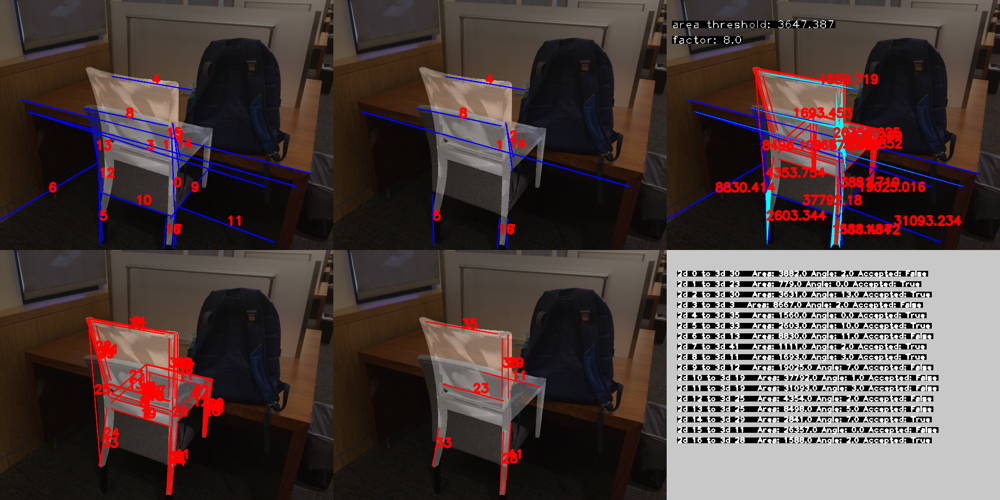


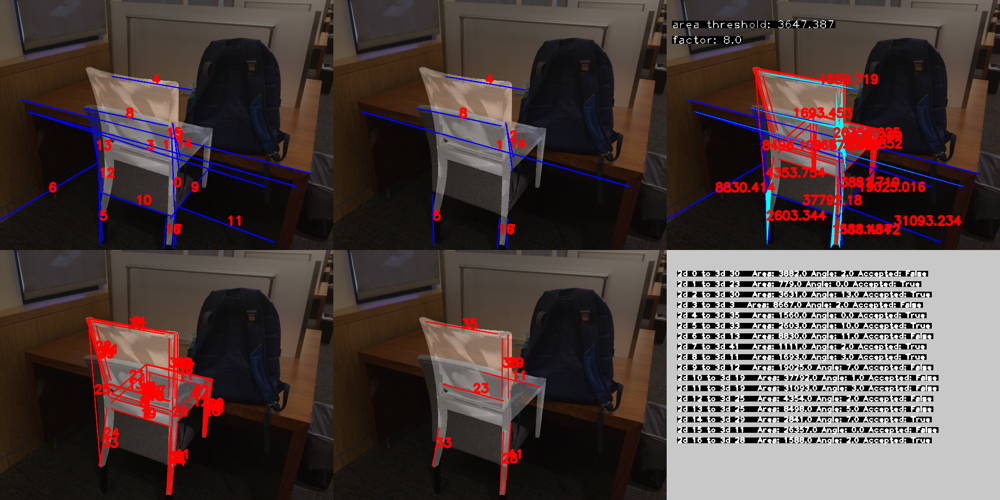

In [106]:
# ipyplot.plot_images([outputs[0][1][0],outputs[1][1][0]], max_images=20, img_width=600)
ipyplot.plot_images([output[1][0] for output in outputs], max_images=20, img_width=1000)


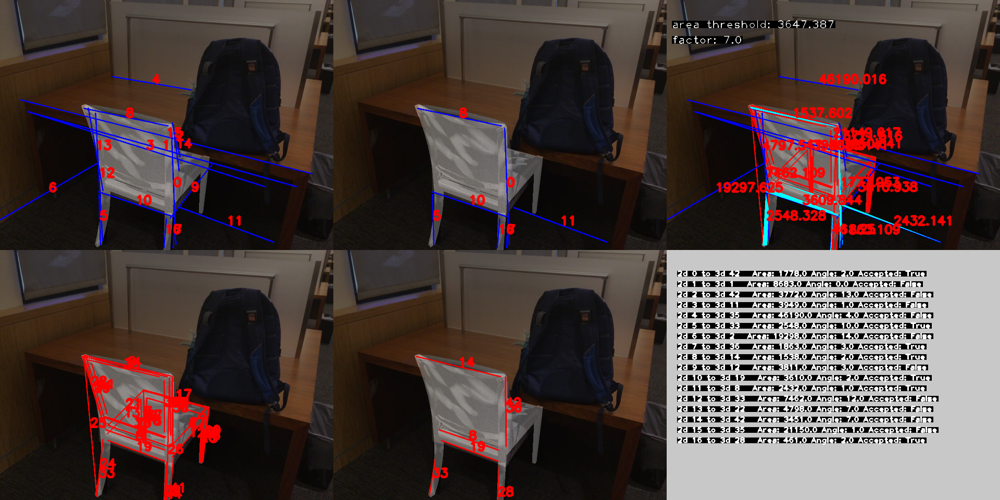


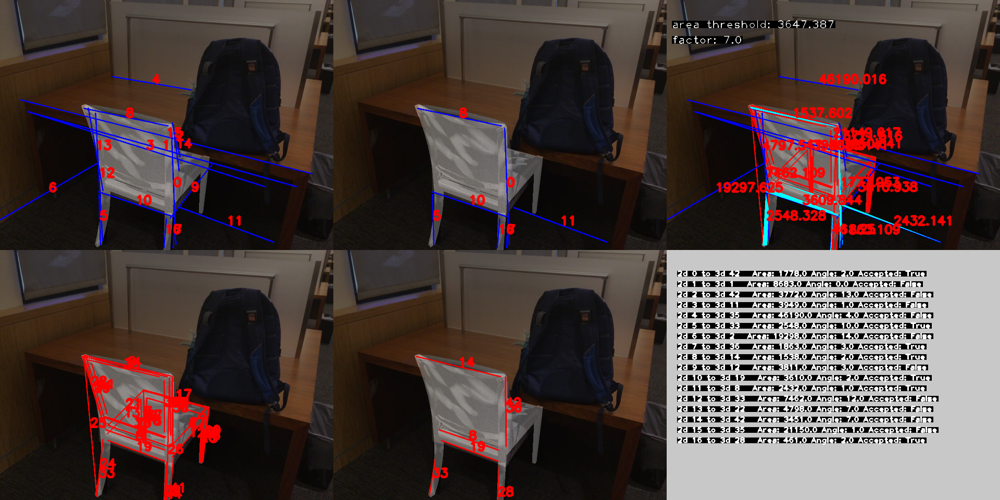

In [107]:
# CLOSEST TO GT TS
ipyplot.plot_images([output[1][1] for output in outputs], max_images=20, img_width=1000)

In [108]:
(0.05 * 1296)**2

def get_thrshold(area):
    return area**0.5 / 1296
get_thrshold(3640)

0.04655278743518011

In [109]:

for i in range(len(configs)):
    pose_information,imgs,Ts,factors,area_accepted_all_Ts,img_annotation = outputs[i]
    # have zeros if not 
    # np.array(area_accepted_all_Ts)
    create_k3d_plot(np.array(Ts),np.array(area_accepted_all_Ts),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='min',relative_highlight_size=1)
    # print(area_accepted_all_Ts)

ValueError: min() arg is an empty sequence

In [ ]:
# in image x point left, y points up and z points into image
for i in range(len(configs)):
    pose_information,imgs,Ts,factors,area_accpeted_all_Ts,img_annotation = outputs[i]
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1.)

Output()

In [ ]:
for i in range(len(configs)):
    pose_information,imgs,Ts,factors,area_accpeted_all_Ts,img_annotation = outputs[i]

    mask_factors = np.array(factors) > 7.5
    factors = 1- mask_factors * 1
    print(Ts[mask_factors])
    create_k3d_plot(np.array(Ts),np.array(factors),np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),relative_highlight_size=1)


tensor([[-0.2455, -0.3143,  1.4871],
        [ 0.1045, -0.2149,  1.4871],
        [ 0.1045, -0.0162,  1.4871]])


Output()